<a href="https://colab.research.google.com/github/PCCraveiro/5IADT-Fase03-Grupo25/blob/main/Distilbert_base_uncased-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Tech Challenge: Fine-Tuning de LLM

Este notebook implementa um pipeline completo de fine-tuning para modelos de linguagem (LLMs) no Google Colab, utilizando o dataset **The AmazonTitles-1.3MM**. Nosso objetivo foi desenvolver um modelo capaz de responder perguntas sobre os títulos dos produtos, gerando respostas baseadas nas descrições extraídas do dataset.

<br>

**Turma 5IADT | Grupo 25**

🧑 Diego Henrique Silva - RM361935 - [diegosource@gmail.com](mailto:diegosource@gmail.com) <br>
🧑 Leandro Henrique Cavalcanti Bernardes - RM362274 - [leandro.bernardes@hotmail.com](mailto:leandro.bernardes@hotmail.com) <br>
🧑 Paulo César Craveiro - RM363961 - [pccraveiro@gmail.com](mailto:pccraveiro@gmail.com) <br>
🧑 Reynaldo Teixeira Santos - RM360956 - [reynaldots@gmail.com](mailto:reynaldots@gmail.com) <br>
🧑 Rodrigo Mendonca de Souza - RM364563 - [rodrigo@volus.com](mailto:rodrigo@volus.com) <br>

<br>

## 🔗 Recursos do Projeto

🐙 GitHub: https://github.com/PCCraveiro/5IADT-Fase03-Grupo25.git
<br>
📂 Google Drive: https://drive.google.com/drive/folders/1FJtSSwmbTMIyTN7UePVFGkvTSZKAJTgQ?usp=drive_link
<br>
▶️ YouTube: https://youtu.be/WVPbp1ea0Uc

<br>

## 🎯 Objetivos

Neste desafio, realizamos o fine-tuning de diversos foundation models com o objetivo de selecionar o que melhor se adequasse à tarefa, levando em consideração limitações computacionais e qualidade dos resultados gerados.

<br>

## 🚀 Metodologia Inicial

Iniciamos desenvolvendo funções para baixar e organizar o arquivo JSON com os dados de treinamento, otimizando o uso do Google Drive para evitar downloads e descompactações repetidas. Para agilizar os testes, parametrizamos a quantidade de exemplos usados, focando em encontrar o modelo mais adequado para o problema proposto.

<br>

## 🧠 Modelos Avaliados

Durante a fase de experimentação, testamos os seguintes modelos:

- **microsoft/DialoGPT-medium:** Treinamento pesado com resultados insatisfatórios, mesmo com ajustes de parâmetros.
- **Meta-LLaMA / NousResearch (LLaMA-2 7B):** Restrição de acesso dificultou a automação, exigindo autenticação.
- **Mistral 7B (unsloth/mistral-7b-instruct-v0.2-bnb-4bit):** Problemas de compatibilidade com métodos do Hugging Face/Transformers impediram seu uso.
- **FLAN-T5:** Modelo otimizado para instruções, sem barreiras de acesso. Apesar de usar uma GPU potente e ajustar parâmetros, obtivemos pouca evolução nos resultados.
- **distilbert-base-uncased:** Versão compacta e otimizada do BERT, que combina boa performance com baixo custo computacional, ideal para ambientes com limitações de recurso ou quando se busca agilidade no treinamento.

<br>

## 💡 Escolha Final

Optamos por utilizar o **distilbert-base-uncased**, que apresentou bons resultados em experimentos com volumes reduzidos de dados, além de ser eficiente na utilização da GPU escolhida (A100, 40GB VRAM), garantindo um bom equilíbrio entre qualidade e eficiência computacional para o desafio proposto.

<br>

## 🖥 Ambiente

Utilizamos **GPU A100** que oferecem bom espaço (40GB VRAM).
  
<br>

## ⚡ Etapas
&emsp; ⚙️ Configurar ambiente

&emsp; 📥 Carregamento e Pré-processamento

&emsp; 📝 Tokenização do Dataset

&emsp; 🤖 Treinamento do Modelo

&emsp; 📊 Avaliação dos resultados
  
<br>



## ⚙️ Configurar ambiente

- Atualização / Instalação de pacotes Python e importação das bibliotecas;
- Conexão com o Google Drive para armazebar os resultados e buscar o json (caso já tenha sido baixado anteriormente);
- Configurações Globais e Hiperparâmetros;
- Funções Auxilizres;

In [ ]:
# ==============================================================================
# 1. INSTALAÇÃO DE DEPENDÊNCIAS
# ==============================================================================
!pip install --upgrade pip -q
!pip install --upgrade \
    torch torchvision torchaudio \
    transformers datasets tokenizers accelerate \
    scikit-learn pandas tqdm google-colab \
    gdown evaluate -q

# Forçando o pyarrow para uma versão compatível:
!pip install pyarrow==19.0.0 -q

print("✅ Dependências instaladas com sucesso!")
print(" --> O alerta de incompatibilidade de versões do 'PyArrow' não impacta em nada a execução desse Notbook.")

# ==============================================================================
# 2. IMPORTS CONSOLIDADOS
# ==============================================================================
import torch
from torch.nn import CrossEntropyLoss

# Para uso eficiente de convoluções e operações de GPU
torch.backends.cudnn.benchmark = True

import gdown
import zipfile
import gzip
import os
import shutil
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
from collections import Counter
import json
import evaluate

from datasets import ClassLabel
from datasets import Dataset

# Hugging Face
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DistilBertTokenizer, DistilBertForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from transformers.trainer_callback import EarlyStoppingCallback

# Google Colab
from google.colab import drive

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

# ==============================================================================
# 3. CONEXÃO COM GOOGLE DRIVE
# ==============================================================================
# Conecta ao GoogleDrive para salvar os resultados e modelos.
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 79.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.1.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.0 which is incompatible.
✅ Dependências instaladas com sucesso!
 --> O alerta de incompatibilidade de versões do 'PyArrow' não impacta em nada a execução desse Notbook.
Mounted at /content/drive


In [ ]:
# ==============================================================================
# 4. CONFIGURAÇÕES GLOBAIS E HIPERPARÂMETROS (AJUSTADO PARA BERT)
# ==============================================================================
# --- Configurações de Caminhos ---
DATA_DIR = "/content/drive/MyDrive/tech_challenge"
DRIVE_JSON_PATH = f"{DATA_DIR}/trn.json"
LOCAL_JSON_PATH = "./amazon_titles/LF-Amazon-1.3M/trn.json"
OUTPUT_DIR = "/content/drive/MyDrive/tech_challenge/bert_amz_titles"
CACHE_DIR = "./cache"

# --- Hiperparâmetros do Modelo e Treinamento ---
MODEL_NAME = "distilbert-base-uncased"
BATCH_SIZE = 1408
MAX_LENGTH = 384
EPOCHS = 10
LR = 3e-5
WARMUP_STEPS = 500
WEIGHT_DECAY = 0.01
GRAD_ACC = 1
FP16 = torch.cuda.is_available() # Ativa FP16 apenas se a GPU estiver disponível
GRAD_CHECKPOINT = True
WORKERS = 6                      # Número de workers para o dataloader
VALIDATION_SPLIT = 0.2           # Usaremos uma divisão fixa de 20% para validação
RANDOM_SEED = 42

# Tamanho da amostra de exemplo a ser usado (se zero pega o dataset inteiro).
SAMPLES_EXAMPLES = 0

# --- Controle de Semente para Reprodutibilidade ---
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

In [ ]:
# ==============================================================================
# 5. FUNÇÕES AUXILIARES PARA DOWNLOAD E CARREGAMENTO
# ==============================================================================

def download_extract_file(extract_dir):
    file_id = "12zH4mL2RX8iSvH0VCNnd3QxO4DzuHWnK"
    output = "amazon_titles.zip"
    print(f"📥 Iniciando download de {output}...")
    gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ ZIP descompactado em {extract_dir}")

    gz_path = os.path.join(extract_dir, "LF-Amazon-1.3M", "trn.json.gz")
    json_path = os.path.join(extract_dir, "LF-Amazon-1.3M", "trn.json")

    with gzip.open(gz_path, 'rt', encoding='utf-8') as f_in:
        with open(json_path, 'w', encoding='utf-8') as f_out:
            f_out.write(f_in.read())
    print(f"✅ trn.json.gz descompactado para {json_path}")
    return json_path

def get_dataset_file(local_path, drive_path):
    if os.path.isfile(local_path):
        print(f"✅ Arquivo já existe localmente: {local_path}")
        return local_path

    folder = Path(local_path).parent
    folder.mkdir(parents=True, exist_ok=True)

    if os.path.ismount("/content/drive"):
        print("📂 Google Drive está montado.")
        if os.path.isfile(drive_path):
            print("📥 Copiando arquivo do Drive para o ambiente local...")
            shutil.copy(drive_path, local_path)
            print(f"✅ Copiado para {local_path}")
            return local_path
        else:
            print("❌ Arquivo não encontrado no Google Drive. Iniciando download.")
    else:
        print("❌ Google Drive não está montado. Iniciando download.")

    return download_extract_file(folder)

def load_amazontitles_json(path):
    data = []
    short_texts = 0

    def clean_html_tags(text):
        clean = re.compile('<.*?>')
        return re.sub(clean, '', text)

    with open(path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Lendo arquivo JSON bruto"):
            d = json.loads(line)
            if all(field in d for field in ["uid", "title", "content", "target_ind"]):
                title = (d["title"] or "").strip()
                content = (d["content"] or "").strip()
                target_ind = d["target_ind"]
                if not title or not content or not isinstance(target_ind, list) or len(target_ind) == 0:
                    continue
                label = target_ind[0]
                combined_text = clean_html_tags(title) + " [SEP] " + clean_html_tags(content)
                if len(combined_text.split()) < 5:
                    short_texts += 1
                    continue
                data.append({"text": combined_text, "raw_label": label})

    if short_texts > 0:
        print(f"Descartados {short_texts} exemplos por textos muito curtos.")

    return pd.DataFrame(data)

## 📥 Carregamento e Pré-processamento

- Inicialmente, garantimos o download do arquivo JSON contendo os dados do dataset **The AmazonTitles-1.3MM**, disponível no Google Drive, evitando downloads e descompactações repetidas para otimizar a execução.
- Aplicamos um filtro para permitir a utilização de uma amostra reduzida do dataset (controlado pela variável `SAMPLES_EXAMPLES`), facilitando testes mais rápidos e iterativos.
- Realizamos o agrupamento dos labels originais em um número reduzido de classes gerais para simplificar o problema.
- Implementamos uma etapa de agrupamento das classes raras, definindo que qualquer classe com menos de 300 exemplos seja agrupada em uma nova classe “Outros”, melhorando a robustez do modelo e evitando classes com pouca representatividade.
- Após o agrupamento, remapeamos todas as classes para manter os labels contínuos (0, 1, 2, ...), requisito importante para o modelo.
- Por fim, os dados tratados foram convertidos para o formato da biblioteca `datasets` da Hugging Face, garantindo compatibilidade com o pipeline de treinamento e possibilitando a utilização da coluna `label` como uma classe categórica para estratificação.
  
<br>



In [ ]:
# ==============================================================================
# 6. PIPELINE DE CARREGAMENTO E PRÉ-PROCESSAMENTO (COM AGRUPAMENTO DE CLASSES)
# ==============================================================================

# Garante que o arquivo de dados esteja disponível localmente
local_file_path = get_dataset_file(LOCAL_JSON_PATH, DRIVE_JSON_PATH)

print("\nCarregando e processando dados...")
df = load_amazontitles_json(local_file_path)

# Amostra de exemplos para um treinamento mais rápido (ajuste se necessário)
if SAMPLES_EXAMPLES > 0:
    print(f"Usando uma amostra de {SAMPLES_EXAMPLES:,} exemplos do total de {len(df):,}.")
    df_filtered = df.sample(n=SAMPLES_EXAMPLES, random_state=RANDOM_SEED).dropna().reset_index(drop=True)
else:
    print(f"Usando todos os exemplos -  total de {len(df):,}.")
    df_filtered = df.dropna().reset_index(drop=True)

# Lógica de agrupamento de labels (binning) original
num_general_classes = 25
labels_sampled = df_filtered['raw_label'].tolist()
min_label, max_label = min(labels_sampled), max(labels_sampled)
df_filtered = df_filtered[(df_filtered['raw_label'] >= min_label) & (df_filtered['raw_label'] <= max_label)].copy()
df_filtered['binned_label'] = pd.cut(df_filtered['raw_label'], bins=num_general_classes, labels=False, include_lowest=True)
label_counts = df_filtered['binned_label'].value_counts()
rare_labels = label_counts[label_counts == 1].index
df_filtered = df_filtered[~df_filtered['binned_label'].isin(rare_labels)]
unique_labels_binned = sorted(df_filtered['binned_label'].unique())
label_map_binned = {old_label: new_label for new_label, old_label in enumerate(unique_labels_binned)}
df_filtered['label'] = df_filtered['binned_label'].map(label_map_binned)

print(f"Agrupados {len(set(labels_sampled))} labels originais em {df_filtered['label'].nunique()} classes gerais.")
print("\nDistribuição ANTES do agrupamento de classes raras:")
print(df_filtered['label'].value_counts().sort_index())


# ==============================================================================
# NOVA LÓGICA: AGRUPAMENTO DE CLASSES RARAS EM "OUTROS"
# ==============================================================================
print("\nIniciando o agrupamento de classes raras...")
LIMIAR_CLASSE_RARA = 300 # Define que qualquer classe com menos de 300 exemplos é "rara"

class_counts = df_filtered['label'].value_counts()
classes_comuns = class_counts[class_counts >= LIMIAR_CLASSE_RARA].index.tolist()
classes_raras = class_counts[class_counts < LIMIAR_CLASSE_RARA].index.tolist()

# Mantém apenas as classes comuns e cria uma cópia para evitar warnings
df_agrupado = df_filtered[df_filtered['label'].isin(classes_comuns)].copy()

# Cria um dataframe com as classes raras e atribui a elas um novo label "Outros"
if classes_raras:
    label_outros = len(classes_comuns) # O novo label será o próximo número disponível
    df_raras = df_filtered[df_filtered['label'].isin(classes_raras)].copy()
    df_raras['label'] = label_outros
    # Combina os dataframes
    df_final = pd.concat([df_agrupado, df_raras], ignore_index=True)
    print(f"{len(classes_raras)} classes raras foram agrupadas na nova classe 'Outros' (label {label_outros}).")
else:
    df_final = df_agrupado
    print("Nenhuma classe rara encontrada para agrupar.")


# Remapeia todos os labels para serem contínuos (0, 1, 2, ...)
# Isso é importante para o modelo
unique_labels_final = sorted(df_final['label'].unique())
final_label_map = {old_label: new_label for new_label, old_label in enumerate(unique_labels_final)}
df_final['label'] = df_final['label'].map(final_label_map)

# Atualiza a contagem final de classes
n_classes = df_final['label'].nunique()
print(f"\nO problema foi simplificado para {n_classes} classes no total.")

print("\nDistribuição FINAL das classes (após agrupamento):")
print(df_final['label'].value_counts().sort_index())

# Converte para o formato da biblioteca `datasets`
hf_dataset = Dataset.from_pandas(df_final[['text', 'label']])

# Converte a coluna 'label' para o tipo ClassLabel para permitir a estratificação
hf_dataset = hf_dataset.cast_column("label", ClassLabel(num_classes=n_classes))

# ** IMPORTANTE: A variável df_filtered será substituída pela nova, que contém os dados agrupados **
df_filtered = df_final

📂 Google Drive está montado.
📥 Copiando arquivo do Drive para o ambiente local...
✅ Copiado para ./amazon_titles/LF-Amazon-1.3M/trn.json

Carregando e processando dados...


Lendo arquivo JSON bruto: 0it [00:00, ?it/s]

Descartados 760 exemplos por textos muito curtos.
Usando todos os exemplos -  total de 1,389,643.
Agrupados 257615 labels originais em 25 classes gerais.

Distribuição ANTES do agrupamento de classes raras:
label
0     454040
1     129487
2     127712
3      77607
4      48831
5      72574
6      48718
7      63116
8      51296
9      43041
10     53619
11     55065
12     12330
13     28325
14     19867
15     18550
16     14522
17     12100
18     10807
19     10353
20      8921
21      8376
22      9854
23      7073
24      3459
Name: count, dtype: int64

Iniciando o agrupamento de classes raras...
Nenhuma classe rara encontrada para agrupar.

O problema foi simplificado para 25 classes no total.

Distribuição FINAL das classes (após agrupamento):
label
0     454040
1     129487
2     127712
3      77607
4      48831
5      72574
6      48718
7      63116
8      51296
9      43041
10     53619
11     55065
12     12330
13     28325
14     19867
15     18550
16     14522
17     12100

Casting the dataset:   0%|          | 0/1389643 [00:00<?, ? examples/s]

## 📝 Tokenização e Preparação Final do Dataset

Este estágio consiste na inicialização do tokenizador do modelo instalado (no caso, DistilBERT), seguido pela aplicação de uma função de tokenização em todos os exemplos do dataset. Para isso, utilizamos o método `.map()` do Hugging Face, que processa os dados em lote de forma eficiente, suportando a tokenização de grandes volumes de textos rapidamente, especialmente com `batched=True` e `num_proc=6` para paralelismo em CPU.

A função `tokenize_function` realiza a tokenização de cada texto, aplicando padding até `max_length` e truncando textos mais longos. Após a tokenização, o dataset é dividido em conjuntos de treino e validação, utilizando `train_test_split`, garantindo uma separação estratificada por rótulos (`label`) para manter a distribuição do dataset.

O processo também inclui a preparação do dataset para o treinamento do modelo de classificação de tokens, incluindo o alinhamento de rótulos com subtokens gerados pela tokenização de subpalavras. Essa etapa é vital para tarefas de reconhecimento de entidades nomeadas (NER) ou classificação token-único, garantindo que cada token seja corretamente associado ao seu rótulo original, com tokens especiais como `[CLS]` e `[SEP]` devidamente tratados.

Por fim, os dados processados são convertidos para o formato da biblioteca `datasets` do Hugging Face, ajustando o campo `label` para o tipo `ClassLabel`, o que permite uma estratificação eficiente e compatível com o treinamento do modelo.
  
<br>



In [ ]:
# ==============================================================================
# 7. TOKENIZAÇÃO E PREPARAÇÃO FINAL DO DATASET
# ==============================================================================
print("\nInicializando o tokenizador...")
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    """Função para tokenizar um lote de textos."""
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH
    )

print("Aplicando tokenização ao dataset (pode levar alguns minutos)...")
# O método .map é altamente otimizado e processa os dados em lote
tokenized_dataset = hf_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=2560,
    num_proc=6,
    load_from_cache_file=False)

print(f"\nDividindo os dados em {1-VALIDATION_SPLIT:.0%} para treino e {VALIDATION_SPLIT:.0%} para validação...")
split_dataset = tokenized_dataset.train_test_split(
    test_size=VALIDATION_SPLIT,
    stratify_by_column='label',
    seed=RANDOM_SEED
)

train_dataset = split_dataset['train']
val_dataset = split_dataset['test']

print(f"Tamanho final -> Treino: {len(train_dataset):,}, Validação: {len(val_dataset):,}")


Inicializando o tokenizador...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Aplicando tokenização ao dataset (pode levar alguns minutos)...


Map (num_proc=6):   0%|          | 0/1389643 [00:00<?, ? examples/s]


Dividindo os dados em 80% para treino e 20% para validação...
Tamanho final -> Treino: 1,111,714, Validação: 277,929


## 🤖 Treinamento do Modelo com BERT e Balanceamento de Classes

Nesta etapa, iniciamos a configuração do ambiente de treinamento definindo o dispositivo adequado, priorizando o uso de GPU se disponível para acelerar o processo. Calculamos os pesos das classes com base na frequência dos rótulos no conjunto de treino, aplicando esses pesos para balancear a função de perda e mitigar o impacto do desbalanceamento das classes.

Construímos um trainer customizado que incorpora esses pesos durante o cálculo da perda, garantindo que o modelo aprenda de forma justa para todas as classes, inclusive as minoritárias.

O modelo BERT foi então instanciado usando a classe `AutoModelForSequenceClassification`, configurado para o número ajustado de classes, e o respectivo tokenizer foi carregado. Contabilizamos o uso de técnicas avançadas, como gradient checkpointing, para otimizar o uso de memória durante o treinamento.

Definimos os argumentos de treinamento com parâmetros ajustados como batch size, taxa de aprendizado, número de épocas, além de estratégias eficientes para avaliação, salvamento e logging. O treinamento foi conduzido com monitoramento de métricas como acurácia e F1-score, utilizando early stopping para evitar overfitting.

Finalmente, após o término do treinamento, o melhor modelo e tokenizer foram salvos, prontos para serem utilizados em inferência e avaliações futuras.

<br>

In [ ]:
# ==============================================================================
# 8. TREINAMENTO DO MODELO COM BERT E BALANCEAMENTO DE CLASSES
# ==============================================================================

# --- Define device (GPU or CPU) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")


# --- 1. Calcular os Pesos das Classes ---
train_labels = np.array(train_dataset['label'])
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Pesos calculados para as {n_classes} classes.")

# --- 2. Criar um Trainer Customizado para Usar os Pesos ---
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# --- 3. Inicializar e Treinar o Modelo ---
print("\nInstanciando modelo BERT...")
# MUDANÇA: Usando a classe AutoModel...
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=n_classes,
    cache_dir=CACHE_DIR
)
# MUDANÇA: O tokenizer também usa a classe AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Move o modelo para o dispositivo
model.to(device)


if GRAD_CHECKPOINT:
    model.gradient_checkpointing_enable()

def compute_metrics(eval_pred):
    logits, y_true = eval_pred
    y_pred = np.argmax(logits, axis=1)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    return {"accuracy": acc, "f1": f1}

# Argumentos de Treinamento
training_args = TrainingArguments(output_dir=OUTPUT_DIR, per_device_train_batch_size=BATCH_SIZE, per_device_eval_batch_size=BATCH_SIZE,
                                  gradient_accumulation_steps=GRAD_ACC, learning_rate=LR, num_train_epochs=EPOCHS, weight_decay=WEIGHT_DECAY,
                                  warmup_steps=WARMUP_STEPS, eval_strategy="steps", eval_steps=200, save_steps=200, logging_steps=25,
                                  save_total_limit=2, fp16=FP16, dataloader_num_workers=WORKERS, dataloader_pin_memory=True,
                                  load_best_model_at_end=True, metric_for_best_model="eval_loss", greater_is_better=False,
                                  gradient_checkpointing=GRAD_CHECKPOINT, report_to="none")

trainer = WeightedTrainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=val_dataset,
                          compute_metrics=compute_metrics, callbacks=[EarlyStoppingCallback(early_stopping_patience=5)])

print("\n🚀 Iniciando o treinamento com balanceamento de classes...")
trainer.train()

print("\n✅ Treinamento concluído! Salvando o melhor modelo...")
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"Modelo e tokenizador salvos em '{OUTPUT_DIR}'.")

Usando dispositivo: cuda
Pesos calculados para as 25 classes.

Instanciando modelo BERT...


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Iniciando o treinamento com balanceamento de classes...


Step,Training Loss,Validation Loss,Accuracy,F1
200,2.926900,2.910953,0.257461,0.256265
400,2.796600,2.779314,0.281507,0.285883
600,2.728100,2.710521,0.278938,0.296594
800,2.667400,2.671991,0.294989,0.308358
1000,2.601600,2.628586,0.305880,0.322770
1200,2.561600,2.595946,0.320870,0.336105
1400,2.560300,2.563641,0.327954,0.343383
1600,2.455300,2.534558,0.317455,0.339076
1800,2.458500,2.516480,0.331772,0.351287
2000,2.422200,2.497498,0.319431,0.341889



✅ Treinamento concluído! Salvando o melhor modelo...
Modelo e tokenizador salvos em '/content/drive/MyDrive/tech_challenge/bert_amz_titles'.


## 📊 Avaliação Final dos Resultados

Nesta etapa, realizaremos uma avaliação detalhada do modelo treinado utilizando o conjunto de validação para medir sua performance. Inicialmente, executamos a avaliação controlada pelo framework de treinamento, obtendo métricas agregadas como acurácia e F1-score.

Em seguida, geramos previsões no conjunto de validação para análise granular, expondo o desempenho do modelo em cada classe por meio de um relatório de classificação detalhado, que apresenta métricas como precisão, recall e F1 para cada categoria.

Além disso, visualizamos a matriz de confusão, representando de forma intuitiva os acertos e erros do modelo por classe, o que nos auxilia a identificar padrões e possíveis fontes de erro.

Por fim, realizaremos testes de inferência com uma pergunta inédita, comparando as previsões do modelo antes do fine-tuning (modelo base) e do modelo treinado, para evidenciar o ganho obtido com o processo de treinamento.

Essa etapa é fundamental para validar a qualidade do modelo e certificar-se de que ele responde adequadamente a perguntas baseadas no contexto aprendido durante o fine-tuning.

<br>



📊 Executando avaliação final no conjunto de validação...



Resultados das Métricas Finais:
- eval_loss: 2.4369
- eval_accuracy: 0.3367
- eval_f1: 0.3600
- eval_runtime: 87.2481
- eval_samples_per_second: 3185.5040
- eval_steps_per_second: 2.2690
- epoch: 6.0759

🔎 Gerando previsões para análise detalhada...

📊 Relatório de Classificação (por classe):
              precision    recall  f1-score   support

    Classe 0      0.772     0.521     0.622     90808
    Classe 1      0.273     0.254     0.263     25898
    Classe 2      0.338     0.169     0.225     25543
    Classe 3      0.311     0.376     0.340     15521
    Classe 4      0.178     0.292     0.221      9766
    Classe 5      0.226     0.219     0.222     14515
    Classe 6      0.145     0.226     0.176      9744
    Classe 7      0.281     0.136     0.183     12623
    Classe 8      0.245     0.192     0.215     10259
    Classe 9      0.263     0.246     0.254      8608
   Classe 10      0.270     0.128     0.174     10724
   Classe 11      0.534     0.225     0.316     11013
  

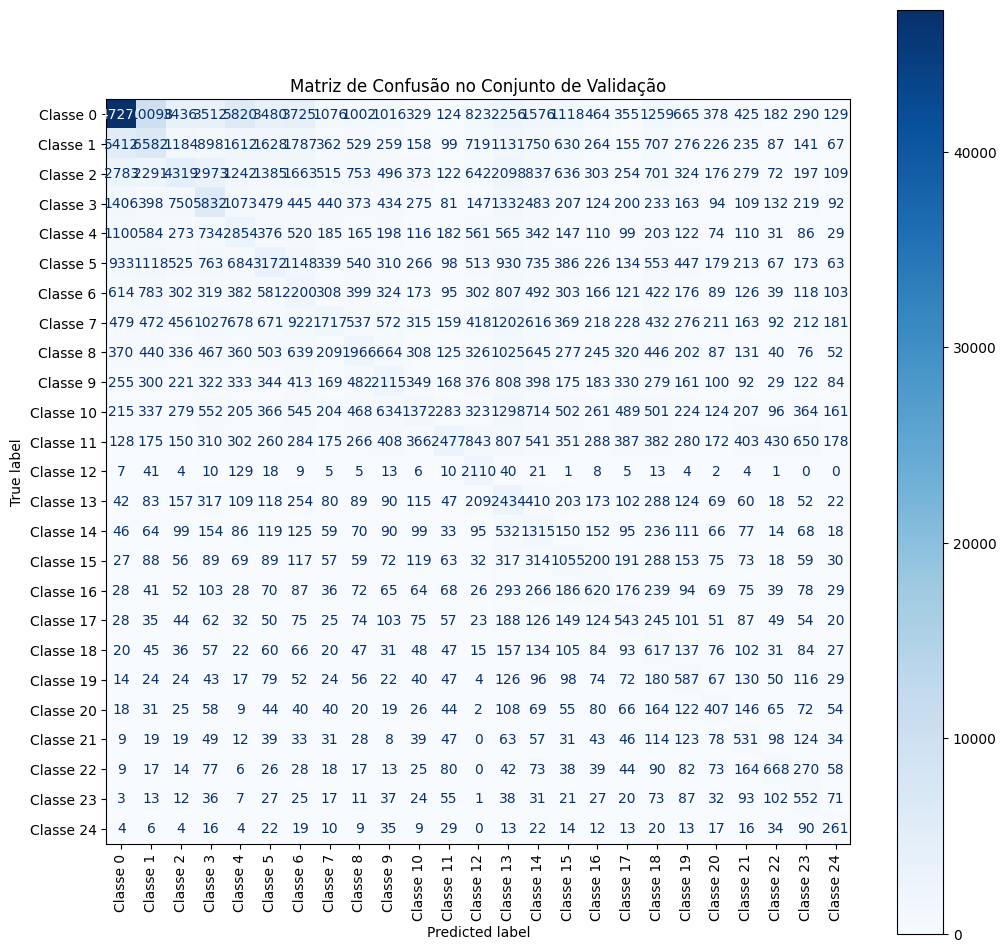

In [ ]:
# ==============================================================================
# 9. AVALIAÇÃO FINAL DETALHADA
# ==============================================================================
print("\n📊 Executando avaliação final no conjunto de validação...")
eval_results = trainer.evaluate()
print("\nResultados das Métricas Finais:")
for key, value in eval_results.items():
    print(f"- {key}: {value:.4f}")

print("\n🔎 Gerando previsões para análise detalhada...")
predictions = trainer.predict(val_dataset)

y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = predictions.label_ids

# Gera nomes de classes para os relatórios
target_names = [f'Classe {i}' for i in range(n_classes)]

# --- Relatório de Classificação ---
print("\n📊 Relatório de Classificação (por classe):")
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

# --- Matriz de Confusão ---
print("\n📊 Matriz de Confusão:")
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

# Plotagem da matriz com tamanho ajustado
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(cmap="Blues", xticks_rotation=90, values_format="d", ax=ax)
plt.title("Matriz de Confusão no Conjunto de Validação")
plt.show()


In [ ]:
# ==============================================================================
# 10. TESTE COM UMA NOVA PERGUNTA (CORRIGIDO COM AUTO CLASSES)
# ==============================================================================

# --- Defina sua pergunta de teste aqui ---
pergunta_teste = "4k monitor for gaming with high refresh rate"

# --- Mapeamento de ID para Label (para legibilidade da resposta) ---
id2label = {i: f"Classe Prevista {i}" for i in range(n_classes)}

# --- Verificação de dispositivo (GPU ou CPU) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# ==============================================================================
# Resposta 1: Modelo SEM Treinamento (BERT base)
# ==============================================================================
print("\n" + "="*50)
print("🔎 1. PREVISÃO COM O MODELO ORIGINAL (SEM TREINAMENTO)")
print("="*50)

# Carrega o modelo e tokenizador originais da Hugging Face usando as classes Auto
tokenizer_base = AutoTokenizer.from_pretrained(MODEL_NAME)
model_base = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=n_classes)
model_base.to(device)

# Prepara a pergunta
inputs_base = tokenizer_base(pergunta_teste, return_tensors="pt").to(device)

# Realiza a previsão
with torch.no_grad():
    logits_base = model_base(**inputs_base).logits

previsao_id_base = logits_base.argmax().item()
previsao_label_base = id2label[previsao_id_base]

print(f"Texto da Pergunta: '{pergunta_teste}'")
print(f"➡️ Resposta do Modelo SEM Treinamento: {previsao_label_base} (ID: {previsao_id_base})\n")


# ==============================================================================
# Resposta 2: Modelo COM Treinamento (Carregado do seu diretório)
# ==============================================================================
print("\n" + "="*50)
print("🚀 2. PREVISÃO COM O SEU MODELO TREINADO")
print("="*50)

# MUDANÇA: Carrega o SEU modelo e tokenizador salvos usando as classes Auto
tokenizer_treinado = AutoTokenizer.from_pretrained(OUTPUT_DIR)
model_treinado = AutoModelForSequenceClassification.from_pretrained(OUTPUT_DIR)
model_treinado.to(device)

# Prepara a mesma pergunta
inputs_treinado = tokenizer_treinado(pergunta_teste, return_tensors="pt").to(device)

# Realiza a previsão
with torch.no_grad():
    logits_treinado = model_treinado(**inputs_treinado).logits

previsao_id_treinado = logits_treinado.argmax().item()
previsao_label_treinado = id2label[previsao_id_treinado]

print(f"Texto da Pergunta: '{pergunta_teste}'")
print(f"➡️ Resposta do Modelo COM Treinamento: {previsao_label_treinado} (ID: {previsao_id_treinado})")

Usando dispositivo: cuda

🔎 1. PREVISÃO COM O MODELO ORIGINAL (SEM TREINAMENTO)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Texto da Pergunta: '4k monitor for gaming with high refresh rate'
➡️ Resposta do Modelo SEM Treinamento: Classe Prevista 17 (ID: 17)


🚀 2. PREVISÃO COM O SEU MODELO TREINADO
Texto da Pergunta: '4k monitor for gaming with high refresh rate'
➡️ Resposta do Modelo COM Treinamento: Classe Prevista 3 (ID: 3)
